# Image caption generator with LSTM and CNN

#### Please download the dataset from this link: 
##### Dataset images - https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
##### Dataset text - https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

### Importing lib and dataset

In [1]:
# importing required lib 
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from pickle import load, dump
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.applications.xception import Xception, preprocess_input

In [2]:
# Paths
dataset_text = "C:\\Users\\priya\\Desktop\\Flickr8k_text"
dataset_images = "C:\\Users\\priya\\Desktop\\Flickr8k_Dataset\\Flicker8k_Dataset"

In [3]:
# functions
def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()

def load_photos(filename):
    file = load_doc(filename)
    photos = file.strip().split('\n')
    return set(photo.split('.')[0] for photo in photos)

def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    for line in file.strip().split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id.split('.')[0] in photos:
            if image_id not in descriptions:
                descriptions[image_id] = []
            desc = '<start> ' + ' '.join(image_desc) + ' <end>'
            descriptions[image_id].append(desc)
    return descriptions

def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_length(descriptions):
    lines = dict_to_list(descriptions)
    return max(len(d.split()) for d in lines)


In [4]:
# Loading datasets
train_filename = os.path.join(dataset_text, "Flickr_8k.trainImages.txt")
test_filename = os.path.join(dataset_text, "Flickr_8k.testImages.txt")

train_imgs = load_photos(train_filename)
test_imgs = load_photos(test_filename)

train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)

# Load features
features = load(open("features.p", "rb"))
train_features = {k + '.jpg': features[k + '.jpg'] for k in train_imgs}
test_features = {k + '.jpg': features[k + '.jpg'] for k in test_imgs}

# Tokenizer and vocab
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
max_len_xception_model = 32
max_len_baseline = 34

### Defining my model

In [5]:
# Xception model
###################################
def define_xception_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

### Defining baseline model

In [6]:
# A simple baseline Model
###################################
def define_baseline_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dense(256, activation='relu')(inputs1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe1, se2])
    outputs = Dense(vocab_size, activation='softmax')(decoder1)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [7]:
# data_generators
def data_generator_xception_model(descriptions, features, tokenizer, max_length):
    while True:
        for key, desc_list in descriptions.items():
            feature = features[key][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    feature_input = np.expand_dims(feature, axis=0)
                    in_seq = np.expand_dims(in_seq, axis=0)
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    out_seq = np.expand_dims(out_seq, axis=0)

                    yield ((feature_input, in_seq), out_seq)

def data_generator_baseline(descriptions, features, tokenizer, max_length):
    while True:
        for key, desc_list in descriptions.items():
            feature = features[key][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    feature_input = np.expand_dims(feature, axis=0)
                    in_seq = np.expand_dims(in_seq, axis=0)
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    out_seq = np.expand_dims(out_seq, axis=0)

                    yield ((feature_input, in_seq), out_seq)

### Training models

In [8]:
# train_models
xception_model_model = define_xception_model(vocab_size, max_len_xception_model)
baseline_model = define_baseline_model(vocab_size, max_len_baseline)

steps = len(train_descriptions)

xception_ds = tf.data.Dataset.from_generator(
    lambda: data_generator_xception_model(train_descriptions, train_features, tokenizer, max_len_xception_model),
    output_signature=(
        (tf.TensorSpec(shape=(1, 2048), dtype=tf.float32),
         tf.TensorSpec(shape=(1, max_len_xception_model), dtype=tf.float32)),
         tf.TensorSpec(shape=(1, vocab_size), dtype=tf.float32))
)

baseline_ds = tf.data.Dataset.from_generator(
    lambda: data_generator_baseline(train_descriptions, train_features, tokenizer, max_len_baseline),
    output_signature=(
        (tf.TensorSpec(shape=(1, 2048), dtype=tf.float32),
         tf.TensorSpec(shape=(1, max_len_baseline), dtype=tf.float32)),
         tf.TensorSpec(shape=(1, vocab_size), dtype=tf.float32))
)

xception_model_history = xception_model_model.fit(xception_ds, epochs=10, steps_per_epoch=steps, verbose=1)
baseline_history = baseline_model.fit(baseline_ds, epochs=10, steps_per_epoch=steps, verbose=1)


Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 373s 62ms/step - loss: 6.1921
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 372s 62ms/step - loss: 5.4374
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 370s 62ms/step - loss: 5.5110
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 370s 62ms/step - loss: 5.4488
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 370s 62ms/step - loss: 5.6557
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 370s 62ms/step - loss: 5.7757
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 370s 62ms/step - loss: 5.7137
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 373s 62ms/step - loss: 5.4108
Epoch 9/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 372s 62ms/step - loss: 5.6859
Epoch 10/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 370s 62ms/step - loss: 5.2738
Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 231s 38ms/step - loss: 6.0466
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 229s 38ms/step - loss: 5.1450
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 230s 38ms/step - loss: 5.1062
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 228s 38ms/step - loss

### Evaluating models

In [9]:
#evaluating results
from nltk.translate.bleu_score import corpus_bleu

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def evaluate_model(model, descriptions, photos, tokenizer, max_length, limit=30):
    actual, predicted = list(), list()
    count = 0
    for key, desc_list in descriptions.items():
        if count >= limit:
            break
        y_pred = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        y_pred = y_pred.split()
        actual.append(references)
        predicted.append(y_pred)
        count += 1
    return actual, predicted

# Evaluate
actual_xception_model, predicted_xception_model = evaluate_model(
    xception_model_model, test_descriptions, test_features, tokenizer, max_len_xception_model, limit=30)

actual_baseline, predicted_baseline = evaluate_model(
    baseline_model, test_descriptions, test_features, tokenizer, max_len_baseline, limit=30)

# BLEU Scores
print("\nXception Model BLEU Scores:")
print('BLEU-1: %f' % corpus_bleu(actual_xception_model, predicted_xception_model, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_xception_model, predicted_xception_model, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_xception_model, predicted_xception_model, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_xception_model, predicted_xception_model, weights=(0.25, 0.25, 0.25, 0.25)))

print("\nBaseline Model BLEU Scores:")
print('BLEU-1: %f' % corpus_bleu(actual_baseline, predicted_baseline, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_baseline, predicted_baseline, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_baseline, predicted_baseline, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_baseline, predicted_baseline, weights=(0.25, 0.25, 0.25, 0.25)))


Xception Model BLEU Scores:
BLEU-1: 0.229734
BLEU-2: 0.137840
BLEU-3: 0.086765
BLEU-4: 0.000000

Baseline Model BLEU Scores:
BLEU-1: 0.215946
BLEU-2: 0.112934
BLEU-3: 0.072475
BLEU-4: 0.000000


C:\Users\priya\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


### Visualizing results

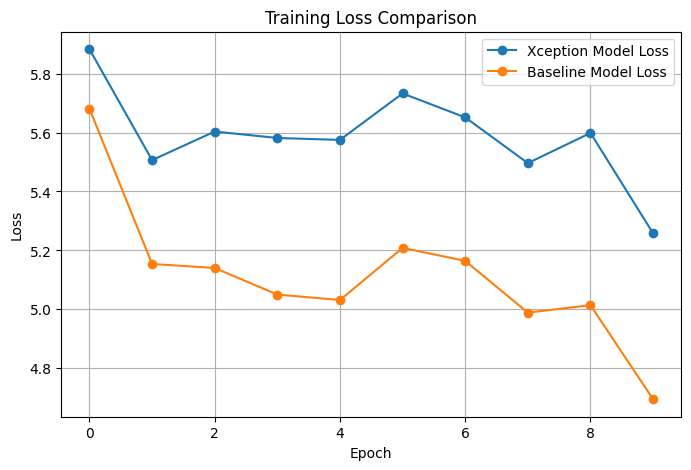

In [10]:
# Plot Loss Curves
plt.figure(figsize=(8,5))
plt.plot(xception_model_history.history['loss'], label='Xception Model Loss', marker='o')
plt.plot(baseline_history.history['loss'], label='Baseline Model Loss', marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


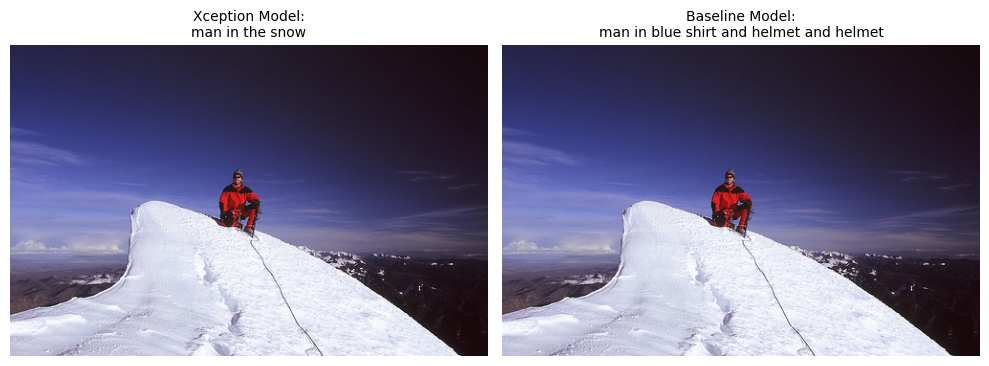

In [17]:
# Visualize Captions for Same Image
img_path = "C:\\Users\\priya\\Desktop\\Flickr8k_Dataset\\Flicker8k_Dataset\\55473406_1d2271c1f2.jpg"
img = Image.open(img_path)

# Helper to extract image features
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image!")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:  # RGBA -> RGB
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

pretrained_xception = Xception(include_top=False, pooling='avg')
photo = extract_features(img_path, pretrained_xception)

xception_caption = generate_desc(xception_model_model, tokenizer, photo, max_len_xception_model)
baseline_caption = generate_desc(baseline_model, tokenizer, photo, max_len_baseline)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title("Xception Model:\n" + xception_caption.replace('start','').replace('end','').strip(), fontsize=10)

plt.subplot(1,2,2)
plt.imshow(img)
plt.axis('off')
plt.title("Baseline Model:\n" + baseline_caption.replace('start','').replace('end','').strip(), fontsize=10)

plt.tight_layout()
plt.show()


In [15]:
# Show Comparison
###################################
print("\nXception Model Generated Caption:\n", xception_caption)
print("\nBaseline Model Generated Caption:\n", baseline_caption)



Xception Model Generated Caption:
 start man in the snow end

Baseline Model Generated Caption:
 start man in blue shirt and helmet and helmet end
